In [4]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.3.1/en_core_web_md-2.3.1.tar.gz

     |████████████████████████████████| 50.8MB 75kB/s 
     |████████████████████████████████| 10.0MB 205kB/s 
     |████████████████████████████████| 2.1MB 42.0MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-cp36-none-any.whl size=50916643 sha256=a5ba6704fd71113dfdce44a418e6475c4784e52d6600b34cff211d5b78cde922
  Stored in directory: /root/.cache/pip/wheels/6e/65/3a/34cdc26d4084d1d1f1e2ec9914964759ea17aa382c53a57d9f
Successfully built en-core-web-md
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [1]:
import os
import pickle

import numpy as np
import spacy

from spacy.tokenizer import Tokenizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving submission_db.sqlite3 to submission_db.sqlite3


In [3]:
import pandas as pd
import sqlite3
import numpy as np

def refresh_connection_and_cursor():
  try:
    c.close()
    conn.close()
  except: pass
  conn = sqlite3.connect('/content/submission_db.sqlite3')
  c = conn.cursor()
  return conn, c

conn, c = refresh_connection_and_cursor()

df = pd.read_sql_query(
    "select * from submission_table order by random() limit 100000;", 
    conn)

c.close()
conn.close()

In [4]:
df.shape

(99502, 5)

In [5]:
df.head(10)

,subreddit_name,subreddit_id,subreddit_subs,title,text
0,VALORANT,2dkvmc,645752,I made a little compil of my BigBrain Time wit...,
1,totalwar,2rq9c,262747,Everytime when i want to kill a undead lord,
2,cursedcomments,hw1ju,2085600,Cursed_jiggle,
3,leagueoflegends,2rfxx,4596206,Triple end game animation that happened while ...,
4,SkincareAddiction,2tbbg,1215975,[Humor] Me whenever someone recommends to patc...,
5,MovieDetails,3md1s,1900076,"In Annihilation, the two deer that Lena sees m...",
6,teenagers,2rjli,2160575,Good job,
7,starterpacks,34o9s,1578951,Growing up in an ex-soviet country starter pack,
8,starterpacks,34o9s,1578951,Things people like to feel weirdly superior ab...,
9,GlobalOffensive,2sqho,1187767,overpass was wild in 2014,


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99502 entries, 0 to 99501
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subreddit_name  99502 non-null  object
 1   subreddit_id    99502 non-null  object
 2   subreddit_subs  99502 non-null  int64 
 3   title           99502 non-null  object
 4   text            99502 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
# filter out the rows with no significant subreddit text
df = df[[len(i)>100 for i in df['text']]]
df.shape

(18568, 5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(16194, 5)

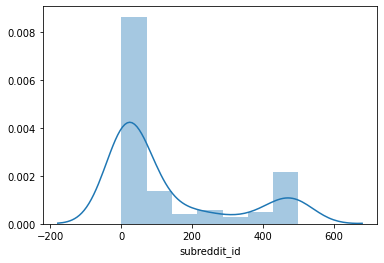

In [8]:
# filter out the rows with low count of subreddit_ids
subid_count = df['subreddit_id'].value_counts(ascending=False)
import seaborn as sns
# y axis is density plot
sns.distplot(subid_count);

df = df.groupby('subreddit_id').filter(lambda x: (x['subreddit_id'].value_counts()>50) &
                                       (x['subreddit_id'].value_counts()<500))
df.shape

In [9]:
df[['title', 'text']] = df[['title', 'text']].astype('str')
df.dtypes[['title', 'text']]

title    object
text     object
dtype: object

In [10]:
# filter out non word and non space characters.
# lower case and remove extra spaces
df['clean_text'] = df['text'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
df['clean_title'] = df['title'].str.replace("[^\w\s']",' ').str.lower().apply(lambda row: ' '.join(row.split()))
df['clean_text'][:10]

15    is this some reference i'm oblivious to why di...
17    found a reddit user that s 15 years old and po...
19    https www bloomberg com politics articles 2018...
20    every guardian begins as a newborn creature wh...
22    i'm attempting to pay a bill in euros if i try...
23    last updated at 05 23 2019 05 23 2019 v3 1 0 w...
24    i went to the police station with my ex s the ...
28    i've seen a lot of bullish and bearish talk on...
40    hi i'm rushan abbas i'm one of the uyghur peop...
47    just saw this pop up https imgur com a 7aebm2r...
Name: clean_text, dtype: object

In [11]:
df['joint_text'] = df[['clean_title', 'clean_text']].agg('-'.join, axis=1)
print(df.shape)
df.head(10)

(16194, 8)


,subreddit_name,subreddit_id,subreddit_subs,title,text,clean_text,clean_title,joint_text
15,OutOfTheLoop,2xinb,1918861,What's up with the question on r/askreddit ask...,Is this some reference I'm oblivious to? Why d...,is this some reference i'm oblivious to why di...,what's up with the question on r askreddit ask...,what's up with the question on r askreddit ask...
17,help,2qh4a,354811,15 year old user,Found a reddit user that’s 15 years old and po...,found a reddit user that s 15 years old and po...,15 year old user,15 year old user-found a reddit user that s 15...
19,investing,2qhhq,1166100,"Trump Signs 25% Tariff on Foreign Steel, 10% T...",https://www.bloomberg.com/politics/articles/20...,https www bloomberg com politics articles 2018...,trump signs 25 tariff on foreign steel 10 tari...,trump signs 25 tariff on foreign steel 10 tari...
20,DestinyTheGame,2vq0w,1771547,"Humanity is totally fucked, and Zavala is the ...",Every Guardian begins as a newborn creature. W...,every guardian begins as a newborn creature wh...,humanity is totally fucked and zavala is the o...,humanity is totally fucked and zavala is the o...
22,PersonalFinanceCanada,2tasy,243862,"[RANT] As a Canadian, I just have to say that ...",I'm attempting to pay a bill in Euros. If I tr...,i'm attempting to pay a bill in euros if i try...,rant as a canadian i just have to say that we ...,rant as a canadian i just have to say that we ...
23,jailbreak,2r8c5,560790,[Release] unc0ver v3.1.0 is now out - The bigg...,Last updated at: 05/23/2019\n\n05/23/2019 - v3...,last updated at 05 23 2019 05 23 2019 v3 1 0 w...,release unc0ver v3 1 0 is now out the biggest ...,release unc0ver v3 1 0 is now out the biggest ...
24,legaladvice,2rawz,1348164,UPDATE Ex is saying that she lives with me and...,I went to the police station with my ex’s(the ...,i went to the police station with my ex s the ...,update ex is saying that she lives with me and...,update ex is saying that she lives with me and...
28,stocks,2qjfk,852723,Beyond Meat (BYND) fundamental analysis with m...,I've seen a lot of bullish and bearish talk on...,i've seen a lot of bullish and bearish talk on...,beyond meat bynd fundamental analysis with my ...,beyond meat bynd fundamental analysis with my ...
40,IAmA,2qzb6,20451737,I am Rushan Abbas - Uyghur Activist and surviv...,"Hi, I'm Rushan Abbas. I'm one of the Uyghur P...",hi i'm rushan abbas i'm one of the uyghur peop...,i am rushan abbas uyghur activist and survivor...,i am rushan abbas uyghur activist and survivor...
47,Twitch,2s0fe,862435,DrDisrepect banned on twitch??,Just saw this pop up.\n\n[https://imgur.com/a...,just saw this pop up https imgur com a 7aebm2r...,drdisrepect banned on twitch,drdisrepect banned on twitch-just saw this pop...


In [12]:
# Number of subreddit categories to classify on
len(df['subreddit_name'].value_counts())

56

In [13]:
# Sample 50 subreddit in each category
df = df.groupby('subreddit_name').apply(lambda x: x.sample(n=50, replace=False, random_state=1)).reset_index(drop = True)

In [14]:
df['subreddit_name'].value_counts()

explainlikeimfive        50
VALORANT                 50
OutOfTheLoop             50
TheSilphRoad             50
unpopularopinion         50
books                    50
dndnext                  50
investing                50
Home                     50
pcgaming                 50
cringe                   50
AskMen                   50
techsupport              50
assassinscreed           50
DotA2                    50
sex                      50
pathofexile              50
nba                      50
sysadmin                 50
DestinyTheGame           50
help                     50
Twitch                   50
changemyview             50
LifeProTips              50
PersonalFinanceCanada    50
offmychest               50
IAmA                     50
tifu                     50
atheism                  50
summonerschool           50
buildapc                 50
AskHistorians            50
apple                    50
fo76                     50
singapore                50
jailbreak           

In [15]:
print(df.shape)
df.head()

(2800, 8)


,subreddit_name,subreddit_id,subreddit_subs,title,text,clean_text,clean_title,joint_text
0,AskHistorians,2ssp3,1254238,"What would a ""Top 50 Companies of 30AD"" in the...",Looking at top 50 companies of the world in 20...,looking at top 50 companies of the world in 20...,what would a top 50 companies of 30ad in the r...,what would a top 50 companies of 30ad in the r...
1,AskHistorians,2ssp3,1254238,TIL that Tsar Nicholas II asked his first cous...,"I've been reading about WW1 a lot recently, an...",i've been reading about ww1 a lot recently and...,til that tsar nicholas ii asked his first cous...,til that tsar nicholas ii asked his first cous...
2,AskHistorians,2ssp3,1254238,Did people in the past really have more leisur...,There’s a semi-common claim online these days ...,there s a semi common claim online these days ...,did people in the past really have more leisur...,did people in the past really have more leisur...
3,AskHistorians,2ssp3,1254238,Marco Polo is quoted to have said on his death...,It is also possible that the quote refers to t...,it is also possible that the quote refers to t...,marco polo is quoted to have said on his death...,marco polo is quoted to have said on his death...
4,AskHistorians,2ssp3,1254238,"Tomorrow, 152 years ago, John Wilkes Booth wal...","I was watching the Ken Burns ""Civil War"" docum...",i was watching the ken burns civil war documen...,tomorrow 152 years ago john wilkes booth walke...,tomorrow 152 years ago john wilkes booth walke...


In [29]:
#Create the nlp object
nlp = spacy.load("en_core_web_md")
# Use Spacy Embedding to vectorize df['join_text']
X = pd.DataFrame([nlp(str(d)).vector for d in df['joint_text']])
y = df['subreddit_name']
X.shape,  y.shape


((2800, 300), (2800,))

In [41]:
from sklearn.model_selection import train_test_split

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    shuffle=True,
                                                    stratify=y)

In [42]:
X_train.shape, y_train.shape

((2240, 300), (2240,))

In [49]:
# column and row
X[0].shape, X.iloc[0].shape

((2800,), (300,))

In [75]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 15)
nn = NearestNeighbors(n_neighbors = 15)

# Fit the classifier to the data
knn.fit(X_train.values, y_train.values)
nn.fit(X_train.values)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [51]:
knn.score(X_test.values, y_test.values)

0.29464285714285715

In [113]:
def prediction0(model, text, n):
  knnsub = model.kneighbors(nlp(text).vector.reshape(1,-1))
  return df['subreddit_name'].iloc[knnsub[1][0]].drop_duplicates()[:n]

In [122]:
print(df['subreddit_name'].iloc[0])
pred = prediction0(knn, df['joint_text'].iloc[0],10)
pred

AskHistorians


1049    TwoXChromosomes
134            AskWomen
1718               fo76
205      DestinyTheGame
1421           buildapc
1608            dndnext
1361              books
1158              apple
649               Jokes
1802            history
Name: subreddit_name, dtype: object

In [120]:
df['joint_text'].iloc[0]

'what would a top 50 companies of 30ad in the roman world look like-looking at top 50 companies of the world in 2017 made me think how would it compare to past preindustrial lists and even later medieval europe up to the 1500s would it be dominated by agro business and arms manufacturers'

In [123]:
df['joint_text'].iloc[pred.index]

1049    yea these masks aren't fun but when was the la...
134     stolen from r askmen what change did you make ...
1718    bethesda pr is out in full force in the sub ag...
205     make the farm an actual farm let us plant plan...
1421    completed my custom computer case meet the t m...
1608    hot take sorcerers should not have spellcastin...
1361    remember use your libraries-i know this sub ha...
1158    apple stepped up their customer service game t...
649     why is spider man so good at comebacks-because...
1802    europeans discovered america 1000 before the n...
Name: joint_text, dtype: object

In [124]:
user_input = """Wildfires sweeping through the West Coast killed at least 36 people, CNN reports
- The fires have burned across a total of some 4.5 million acres (1.8 million hectares) in Oregon, California, Washington and Idaho, according to Reuters
- Wildfires are causing dangerous air quality and emitting record amounts of carbon dioxide"""
pred = prediction0(knn, user_input, 5)
pred

1774       help
1620    dndnext
1171      apple
2080        nba
1713       fo76
Name: subreddit_name, dtype: object

In [125]:
df['joint_text'].iloc[pred.index]

1774    reddit is spamming me-reddit keeps on spamming...
1620    say that you'll like to play to d d and nobody...
1171    fyi apple deletes your apple music library if ...
2080    nike claims the ninja style headbands unprofes...
1713    saw a level 105 at the overseer's camp wondere...
Name: joint_text, dtype: object

In [126]:
import pickle
# pickle knn model
knnPickle = open('knnpickle', 'wb') 
pickle.dump(knn, knnPickle)   

# pickle the dataframe
df['subreddit_name'].to_pickle("./namedf.pkl")

# nlp pickle
nlpPickle = open('nlppickle', 'wb') 
pickle.dump(nlp, nlpPickle) 

In [127]:
loaded_model = pickle.load(open('knnpickle', 'rb'))
loaded_nlp = pickle.load(open('nlppickle', 'rb'))
loaded_df = pd.read_pickle("./namedf.pkl")

In [135]:
def prediction(pmodel, pnlp, pdf, text, n):
  knnsub = pmodel.kneighbors(nlp(text).vector.reshape(1,-1))
  return pdf.iloc[knnsub[1][0]].drop_duplicates()[:n]

In [136]:
type(user_input)

str

In [137]:
prediction(loaded_model, loaded_nlp, loaded_df, user_input, 10)

1774              help
1620           dndnext
1171             apple
2080               nba
1713              fo76
355            Fitness
1291    assassinscreed
542               IAmA
2031       legaladvice
2178       pathofexile
Name: subreddit_name, dtype: object